<a href="https://colab.research.google.com/github/gabrie1-s/Chagas_analysis/blob/cnn/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Version: CNN_1.0.0

##1. Download files

In [1]:
%%capture
!pip install neptune-notebooks

In [2]:
%%capture
!jupyter nbextension enable --py neptune-notebooks

In [3]:
%%capture
!pip install neptune-client

In [4]:
%%capture
!pip install mat73
!pip install Bayesian-Optimization
!pip install h5py

In [5]:
import keras
import pdb
import gc
import requests

In [6]:
from google.colab import drive
import mat73
import h5py
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
import statistics as st

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/CNN_Chagas/Chagas/cnn

/content/drive/MyDrive/CNN_Chagas/Chagas/cnn


In [9]:
import neptune.new as neptune

/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:51: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-9-37c521bab1e7>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [10]:
run = neptune.init_run(
    project="gabrie1-s/NACA-data-extraction",
    with_id="NAC-18",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1ODlmNWY4ZS0zNmUzLTQ3NWQtYmVkYy05ZmUyMDM4ZGQxMzkifQ==",
    mode="read-only")

https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-18


In [11]:
%cd -

/content


In [12]:
run["data"].download()

In [13]:
!unzip data.zip

Archive:  data.zip
mapname:  conversion of  failed
   creating: dataset/
  inflating: dataset/x_te.npy        
  inflating: dataset/x_tr.npy        
  inflating: dataset/x_va.npy        
  inflating: dataset/y_te.npy        
  inflating: dataset/y_tr.npy        
  inflating: dataset/y_va.npy        


In [14]:
!rm data.zip

In [15]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-18/metadata


# 2. Preprocessing


In [16]:
%cd /content/drive/MyDrive/CNN_Chagas/Chagas/cnn

/content/drive/MyDrive/CNN_Chagas/Chagas/cnn


In [17]:
run = neptune.init_run(
    project="gabrie1-s/NACA-data-extraction",
    custom_run_id="CNN_1.0.0",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1ODlmNWY4ZS0zNmUzLTQ3NWQtYmVkYy05ZmUyMDM4ZGQxMzkifQ==",
    description='''Usando os dados da execução NACA-18, vamos criar um modelo
    de CNN que recebe sinais do NACA-18. Faremos um janelamento de cada sinal
    com janelas de 500 amostras sem interseção''',
    source_files=["cnn.ipynb"],
)  # your credentials

run["code_version"] = "CNN_1.0.0"

<ipython-input-17-cea7231cd26e>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-19


In [18]:
%cd -

/content


In [19]:
x_train = np.load("dataset/x_tr.npy", allow_pickle=True)
x_test = np.load("dataset/x_te.npy", allow_pickle=True)
x_valid = np.load("dataset/x_va.npy", allow_pickle=True)

y_train = np.load("dataset/y_tr.npy", allow_pickle=True)
y_test = np.load("dataset/y_te.npy", allow_pickle=True)
y_valid = np.load("dataset/y_va.npy", allow_pickle=True)

### Sampling of training data

In [20]:
intersection = 0
window_size = 500
n_windows = "max"

In [21]:
def window(signal, intersection, window_size, n):
    s_size = len(signal)
    max_n = (s_size-intersection)/(window_size - intersection)
    samples = []

    if  n == "max" or n > max_n:
        n = max_n
        n = math.floor(n)

    max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
    init = random.randrange(max_begin)
    for i in range(0, n):
        begin = init + i*window_size - i*intersection
        end = begin + window_size
        samples.append(signal[begin:end])


    return samples

In [22]:
def embalance_data(df, intersection, window_size, n):

  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  for index, row in df.iterrows():
    samples = window(row["signals"], intersection, window_size, n)

    for k in range(len(samples)):
      d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)

  return d_train

In [23]:
d_aux_train = pd.DataFrame({'signals': x_train, 'output': y_train})
d_train = embalance_data(d_aux_train, intersection, window_size, n_windows)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'output': y_valid})
d_valid = embalance_data(d_aux_valid, intersection, window_size, n_windows)

# path = 'drive/MyDrive/CNN_Chagas/Chagas/saves/'

# d_aux_train = pd.read_hdf(path + 'd_aux_train1.h5')
# d_aux_train2 = pd.read_hdf(path + 'd_aux_train2.h5')
# d_aux_train = pd.concat([d_aux_train, d_aux_train2])
# del d_aux_train2

# d_train = pd.read_hdf(path + 'd_train1.h5')
# d_train2 = pd.read_hdf(path + 'd_train2.h5')
# d_train = pd.concat([d_train, d_train2])
# del d_train2

# d_aux_valid = pd.read_hdf(path + 'd_aux_valid.h5')
# d_valid = pd.read_hdf(path + 'd_valid.h5')

A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-22-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-22-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-22-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-22-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [24]:
d_train

,signals,output
0,"[-0.8775864194045373, -0.9318362138002914, -0....",2
1,"[-1.8319266512208665, -0.707775847109047, -0.5...",2
2,"[-1.257280572275814, -1.0826293616674305, -0.9...",2
3,"[-4.086815570708698, -4.9258217269049815, -3.7...",2
4,"[-1.895171340867142, -1.7517571289354839, -1.6...",2
...,...,...
401678,"[-2.426913644958284, -3.4437620355243324, -1.4...",1
401679,"[4.241346188715377, 5.233328024969908, 6.22602...",1
401680,"[-31.80361344814052, -33.920441955136724, -26....",1
401681,"[4.177223871994146, 4.063467404067519, 2.95291...",1


In [25]:
# def convert_hdf(data, path, n):
#     end = len(data["signals"])
#     step = math.floor(end/n)
#     flag = False
#     count = 0

#     for i in range(0, end, step):
#         count += 1
#         init = i
#         fim = i+1

#         if fim >= end:
#             fim = end
#             flag = True

#         val = data.loc[init:fim]
#         val.to_hdf(path + str(count) + '.h5', 'df')
#         print(i)
#         if flag == True:
#             break

In [26]:
# d_aux_train = d_aux_train.reset_index(drop=True)

In [27]:
# convert_hdf(d_aux_train, 'd_aux_train', 1)
# convert_hdf(d_train, 'd_train', 1)

# d_aux_valid.to_hdf('d_aux_valid.h5', 'df')
# d_valid.to_hdf('d_valid.h5', 'df')

In [28]:
# len(d_train)

# 3. Implementação da CNN

### 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.utils import shuffle
from math import floor

In [26]:
y_train = d_train["output"].copy()
y_valid = d_valid["output"].copy()

In [27]:
x_train = np.array(list(d_train["signals"]))
x_valid = np.array(list(d_valid["signals"]))

### 3.1.2 Import packages

In [28]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error, classification_report

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [29]:
!pip install scikeras

In [30]:
def print_history(history, classificador, x_valid, y_valid, columns):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #plt.savefig('plot '+classe+'.png')
    plt.show()

    y_pred = classificador.predict(x_valid)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = columns

    y_pred = y_pred.idxmax(axis=1)
    relatorio = classification_report(y_valid, y_pred)
    print(relatorio)

In [31]:
def create_cnn(x_train, y_train, x_valid, y_valid, optimizer):

    #x_train = np.array(list(x_train))
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    y_train = pd.get_dummies(y_train)

    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
    y_valid = pd.get_dummies(y_valid)

    print(y_train.columns)

    input_shape = len(x_train[0])
    k1 = 5
    k2 = 3

    classificador = Sequential()

    for i  in range(0, 5):
      if i == 0:
        classificador.add(Conv1D(filters=64, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
      else:
          classificador.add(Conv1D(filters=64, kernel_size = k1, activation = "relu"))
      # BatchNormalization()

      classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
      # BatchNormalization()
      # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
      classificador.add(MaxPooling1D(pool_size=2))

    classificador.add(Flatten())

    classificador.add(Dense(units=128, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=64, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=32, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=16, activation='relu'))
    classificador.add(Dropout(0.35))

    classificador.add(Dense(2, activation="softmax"))

    classificador.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=0.001), metrics=["accuracy"])

    es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=25)

    checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
                                      save_best_only=True, mode='max')

    history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=150,
                                batch_size=128, callbacks=[checkpoint, es], verbose=1)

    classificador = load_model('_pesos_cnn1d.hdf5')

    return y_train.columns, classificador, history

<class 'keras.optimizers.adamax.Adamax'>
Int64Index([1, 2], dtype='int64')
Epoch 1/150
3139/3139 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9253
Epoch 1: val_accuracy improved from -inf to 0.70341, saving model to _pesos_cnn1d.hdf5
3139/3139 [==============================] - 82s 24ms/step - loss: 0.1801 - accuracy: 0.9253 - val_loss: 2.0401 - val_accuracy: 0.7034
Epoch 2/150
3137/3139 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9947
Epoch 2: val_accuracy did not improve from 0.70341
3139/3139 [==============================] - 75s 24ms/step - loss: 0.0213 - accuracy: 0.9947 - val_loss: 2.8097 - val_accuracy: 0.6955
Epoch 3/150
3139/3139 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9973
Epoch 3: val_accuracy did not improve from 0.70341
3139/3139 [==============================] - 75s 24ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 3.4206 - val_accuracy: 0.6807
Epoch 4/150
3139/3139 [===========

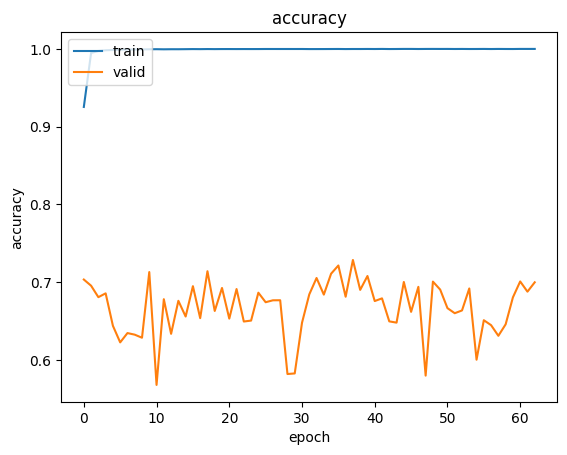

1681/1681 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           1       0.73      0.68      0.70     25541
           2       0.73      0.77      0.75     28240

    accuracy                           0.73     53781
   macro avg       0.73      0.73      0.73     53781
weighted avg       0.73      0.73      0.73     53781



ClientHttpError: ignored

In [33]:
for i in  [Adamax]:
  print(str(i))
  columns, classificador, history = create_cnn(x_train, y_train, x_valid, y_valid, i)
  print_history(history, classificador, x_valid, y_valid, columns)

In [43]:
model = neptune.init_model(
    name="CNN_1.0.0"+str(i),
    key="CNNADAMAX1",  # should be different for your project
    project="gabrie1-s/NACA-data-extraction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1ODlmNWY4ZS0zNmUzLTQ3NWQtYmVkYy05ZmUyMDM4ZGQxMzkifQ==",
  )

https://app.neptune.ai/gabrie1-s/NACA-data-extraction/m/NAC-CNNADAMAX1


In [44]:
model["model/signature"].upload("_pesos_cnn1d.hdf5")

<class 'keras.optimizers.adamax.Adamax'>
Int64Index([1, 2], dtype='int64')
Epoch 1/150
3137/3139 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9402
Epoch 1: val_accuracy improved from -inf to 0.64848, saving model to _pesos_cnn1d.hdf5
3139/3139 [==============================] - 82s 24ms/step - loss: 0.1466 - accuracy: 0.9402 - val_loss: 3.3639 - val_accuracy: 0.6485
Epoch 2/150
3139/3139 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9958
Epoch 2: val_accuracy did not improve from 0.64848
3139/3139 [==============================] - 75s 24ms/step - loss: 0.0169 - accuracy: 0.9958 - val_loss: 4.4021 - val_accuracy: 0.5277
Epoch 3/150
3139/3139 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9976
Epoch 3: val_accuracy did not improve from 0.64848
3139/3139 [==============================] - 75s 24ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 3.9726 - val_accuracy: 0.6446
Epoch 4/150
3139/3139 [===========

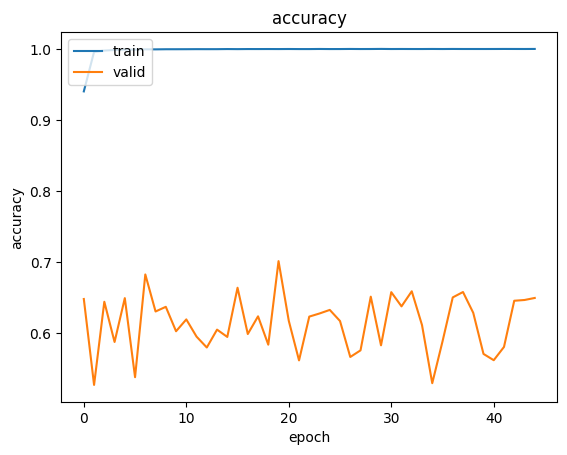

1681/1681 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           1       0.75      0.55      0.64     25541
           2       0.67      0.84      0.75     28240

    accuracy                           0.70     53781
   macro avg       0.71      0.69      0.69     53781
weighted avg       0.71      0.70      0.69     53781



In [45]:
for i in  [Adamax]:
  print(str(i))
  columns, classificador, history = create_cnn(x_train, y_train, x_valid, y_valid, i)
  print_history(history, classificador, x_valid, y_valid, columns)

In [46]:
model = neptune.init_model(
    name="CNN_1.0.0"+str(i),
    key="CNNADAM1",  # should be different for your project
    project="gabrie1-s/NACA-data-extraction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1ODlmNWY4ZS0zNmUzLTQ3NWQtYmVkYy05ZmUyMDM4ZGQxMzkifQ==",
  )

https://app.neptune.ai/gabrie1-s/NACA-data-extraction/m/NAC-CNNADAM1


In [47]:
model["model/signature"].upload("_pesos_cnn1d.hdf5")

In [48]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gabrie1-s/NACA-data-extraction/e/NAC-19/metadata


# 4. Verificando  a precisão com os dados de teste

In [75]:
model = load_model('_pesos_cnn1d.hdf5')

In [76]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

  prediction = model.predict(samples)

  prediction = pd.DataFrame(prediction)
  prediction.columns = [1, 2]
  prediction = prediction.idxmax(axis=1)

  y_pred.append(prediction.mode()[0])

105/105 [==============================] - 0s 3ms/step


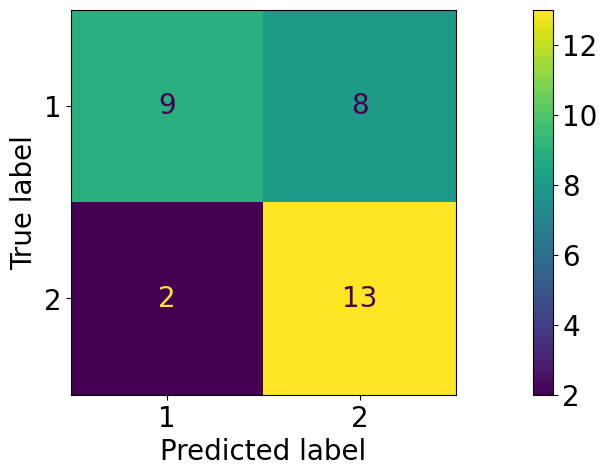

              precision    recall  f1-score   support

           1       0.82      0.53      0.64        17
           2       0.62      0.87      0.72        15

    accuracy                           0.69        32
   macro avg       0.72      0.70      0.68        32
weighted avg       0.72      0.69      0.68        32



In [77]:
plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_test, y_pred)
print(relatorio)